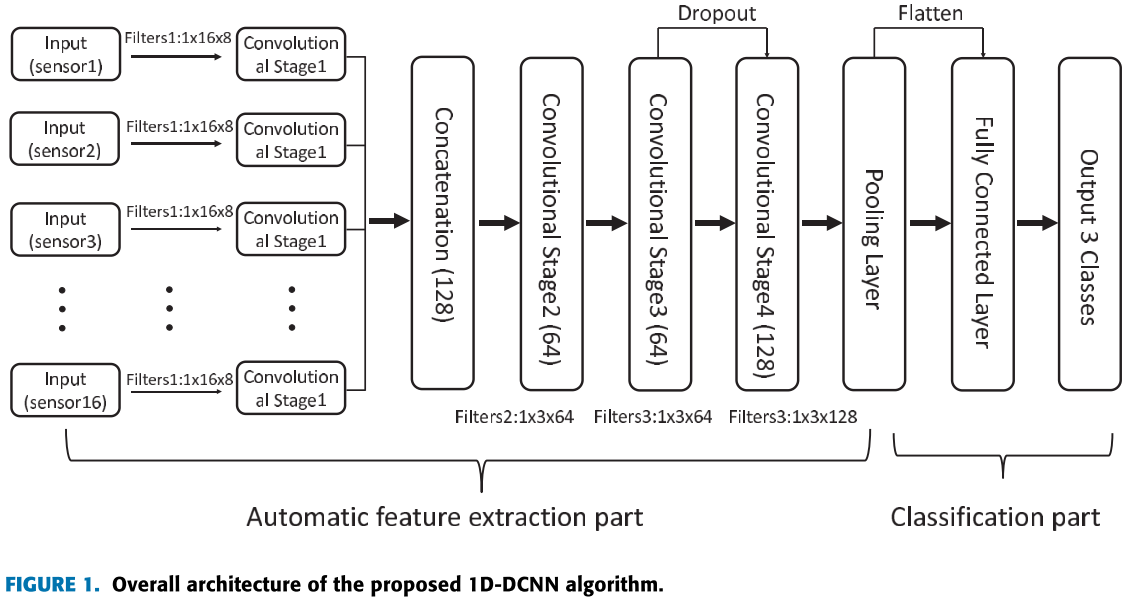

In [66]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss, BCELoss, MultiLabelSoftMarginLoss
import sys
sys.path.append(r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验")
from utils import array_to_tensor, Data_set, model, hamming_score, predict
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [39]:
class Convolutional_block(nn.Module):
    
    def __init__(self, kernel_size1, kernel_size2, kernel_size3, kernel_size4, 
                 channel1, channel2, channel3, channel4, dropout):
        # kernal_size1 = 16, channel1 = 8
        # kernal_size2 = 7, channel2 = 64
        # kernal_size3 = 7, channel3 = 64
        # kernal_size4 = 7, channel4 = 128
        super(Convolutional_block, self).__init__()
        self.conv1 = nn.Conv1d(1, channel1, kernel_size1, 2)
        self.batchnorm1 = nn.BatchNorm1d(channel1)
        self.conv2 = nn.Conv1d(channel1, channel2, kernel_size2, 2)
        self.batchnorm2 = nn.BatchNorm1d(channel2)
        self.conv3 = nn.Conv1d(channel2, channel3, kernel_size3, 2)
        self.batchnorm3 = nn.BatchNorm1d(channel3)
        self.dropout = nn.Dropout(dropout)
        self.conv4 = nn.Conv1d(channel3, channel4, kernel_size4,2 )
        self.batchnorm4 = nn.BatchNorm1d(channel4)
        self.pooling = nn.AvgPool1d(68, 1)
    
    def forward(self, x):
        # x = (batch, seq_len)
        x = x.unsqueeze(1)
        
        # x = (batch, 1, seq_len)
        x = F.relu(self.batchnorm1(self.conv1(x)))
        
        # torch.Size([batch, channel1, 1653])
        x = F.relu(self.batchnorm2(self.conv2(x)))
        
        # torch.Size([batch, channel2, 824])
        x = F.relu(self.batchnorm3(self.conv3(x)))
        
        # torch.Size([batch, channel3, 409])
        x = self.dropout(x)
        x = F.relu(self.batchnorm4(self.conv4(x)))
        # torch.Size([batch, channel4, 202])
       
        x = self.pooling(x)
        # torch.Size([10, 128, 135])
        return x

In [52]:
x = torch.randn(10, 3321)
conv = Convolutional_block(16, 7, 7, 7, 8, 64, 64, 128, 0.2)
x = conv(x)
print(x.shape)

torch.Size([10, 128, 135])


In [53]:
class Fully_connected_layer(nn.Module):
    
    def __init__(self, layer1, layer2, dropout):
        
        super(Fully_connected_layer, self).__init__()
        
        self.fc1 = nn.Linear(128 * 135, layer1)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(layer1, layer2)
        self.fc3 = nn.Linear(layer2, 6)
        
    
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [54]:
fc = Fully_connected_layer(64, 32, 0.2)
x = fc(x)
print(x.shape)

torch.Size([10, 6])


In [55]:
class CNN(nn.Module):
    
    def __init__(self, conv_block, fc_block):
        
        super(CNN, self).__init__()
        
        self.conv = conv_block
        self.fc = fc_block
    
    def forward(self, x):
        x = self.fc(self.conv(x))
        return x

In [56]:
x = torch.randn(10, 3321)
conv = Convolutional_block(16, 7, 7, 7, 8, 64, 64, 128, 0.2)
fc = Fully_connected_layer(64, 32, 0.2)
cnn = CNN(conv, fc)
x = cnn(x)
print(x.shape)

torch.Size([10, 6])


In [57]:
def array_to_tensor(array):
    tensor = torch.from_numpy(array)
    tensor = tensor.type(torch.cuda.FloatTensor)
    return tensor

In [59]:
def Data_set(x, y, batch_size):
    """
    生成data_loader实例。可以定义batch_size
    :param input_data: 希望作为训练input的数据，tensor类型
    :param label_data: 希望作为训练label的数据，tensor类型
    :param batch_size: batch size
    :return: data_loader实例
    """
    data_set = Data.TensorDataset(x, y)
    data_loader = Data.DataLoader(dataset=data_set,
                                  shuffle=True,
                                  batch_size=batch_size,
                                  num_workers=0)
    return data_loader

In [60]:
def train_batch_loss(model, loss_function1, loss_function2, x, y, opt):
        pred = model(x)
        loss1 = loss_function1(pred[:, :3], y[:, :3])
        loss2 = loss_function2(pred[:, 3:], y[:, 3:])
        loss = loss1 + loss2
        loss.backward()
        opt.step()
        opt.zero_grad()
        return np.array(loss.cpu().detach().numpy()), np.array(len(x)), loss2

In [64]:
def valid_batch_loss(model, loss_function1, loss_function2, x, y):
        pred = model(x)
        loss1 = loss_function1(pred[:, :3], y[:, :3])
        loss2 = loss_function2(pred[:, 3:], y[:, 3:])
        loss = loss1 + loss2
        prediction = np.zeros_like(pred.cpu().detach().numpy()[:, :3])
        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                if pred[i, j] > 0.5:
                    prediction[i, j] = 1
                else:
                    prediction[i, j] = 0
        accuracy = accuracy_score(y.cpu().detach().numpy()[:, :3],
                                  prediction)
        hamming = hamming_score(y[:, :3].cpu().detach().numpy(),
                                prediction)
        return np.array(loss.cpu().detach().numpy()), accuracy, hamming, np.array(len(x)), loss2

In [61]:
path1 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\训练集+验证集\train_data.npy"
path2 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\训练集+验证集\train_label.npy"
train_input = np.load(path1)
train_label = np.load(path2)

path1 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\训练集+验证集\val_data.npy"
path2 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\训练集+验证集\val_label.npy"
valid_input = np.load(path1)
valid_label = np.load(path2)

path1 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\测试集\test_data.npy"
path2 = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\甲烷、丙酮、水数据库\数据集\混合气体吸收光谱\测试集\test_label.npy"
test_input = np.load(path1)
test_label = np.load(path2)

In [62]:
train_input = np.vstack((train_input, valid_input))
train_label = np.vstack((train_label, valid_label))
print(train_input.shape)
print(train_label.shape)

(9135, 3321)
(9135, 6)


In [74]:
input1 = array_to_tensor(train_input)
output1 = array_to_tensor(train_label)
train_data_set = Data_set(input1, output1, 256)

input2 = array_to_tensor(test_input)
output2 = array_to_tensor(test_label)
test_data_set = Data_set(input2, output2, 256)


Gpu = torch.device("cuda")
cnn = cnn.to(Gpu)
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

train_loss_list = []
test_loss_list = []
test_acc_list = []
regression_loss_list1 = []
regression_loss_list2 = []
# classification_loss = []
# regression_loss = []

epoch = 3000
for e in range(epoch):
    cnn.train()
    loss, number_of_data, loss2 = zip(*[train_batch_loss(cnn, criterion1, criterion2, x, y, optimizer)
                                        for x, y in train_data_set])
    train_loss = np.sum(np.multiply(loss, number_of_data)) / np.sum(number_of_data)
    train_loss_list.append(train_loss)
    regression_loss = np.sum(np.multiply(loss2, number_of_data)) / np.sum(number_of_data)
    regression_loss_list1.append(regression_loss)
    
    cnn.eval()
    with torch.no_grad():
        val_loss, val_accuracy, val_hamming_score, number_of_data, loss3 = zip(*[valid_batch_loss(cnn,
                                                                                                  criterion1,
                                                                                                  criterion2, x, y)
                                                                                 for x, y in test_data_set])
        val_loss = np.sum(np.multiply(val_loss, number_of_data)) / np.sum(number_of_data)
        test_loss_list.append(val_loss)
        val_accuracy = np.mean(np.array(val_accuracy))
        test_acc_list.append(val_accuracy)
        regression_loss2 = np.sum(np.multiply(loss3, number_of_data)) / np.sum(number_of_data)
        regression_loss_list2.append(regression_loss2)
        print("[Epoch {}/{} Train loss:{:.6f}]\t Validation loss:{:.6f}    Validation accuracy:{:.3f}%".format(e + 1,
                                                                                                              epoch,
                                                                                                              train_loss,
                                                                                                              val_loss,
                                                                                                              val_accuracy))

[Epoch 1/3000 Train loss:0.178418]	 Validation loss:0.193267    Validation accuracy:1.000%
[Epoch 2/3000 Train loss:0.178582]	 Validation loss:0.191922    Validation accuracy:1.000%
[Epoch 3/3000 Train loss:0.178406]	 Validation loss:0.194050    Validation accuracy:1.000%
[Epoch 4/3000 Train loss:0.178428]	 Validation loss:0.191817    Validation accuracy:1.000%
[Epoch 5/3000 Train loss:0.178340]	 Validation loss:0.190679    Validation accuracy:1.000%
[Epoch 6/3000 Train loss:0.178333]	 Validation loss:0.191542    Validation accuracy:1.000%
[Epoch 7/3000 Train loss:0.178378]	 Validation loss:0.188719    Validation accuracy:1.000%
[Epoch 8/3000 Train loss:0.178381]	 Validation loss:0.191131    Validation accuracy:1.000%
[Epoch 9/3000 Train loss:0.178426]	 Validation loss:0.192213    Validation accuracy:1.000%
[Epoch 10/3000 Train loss:0.178351]	 Validation loss:0.191932    Validation accuracy:1.000%
[Epoch 11/3000 Train loss:0.178264]	 Validation loss:0.190988    Validation accuracy:1.00

In [75]:
print("Finished")

Finished


In [76]:
path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\多组分气体识别与浓度检测\数据集\HITRAN_dataset\实验\模型保存\1dcnn.pt"
torch.save(cnn.state_dict(), path)

# 测试结果可视化

In [69]:
def predict(logits, labs):
    components = ["甲烷", "丙酮", "水"]
    prediction = [0 if pred < 0.5 else 1 for pred in logits[:3]]
    for i in range(3):
        if prediction[i] == 0:
            components[i] = ""
            logits[i+3] = 0
    print("================================================")
    print("预测结果为：{} \n".format(prediction))
    print("混合光谱包含的成分为：{} {} {} \n".format(components[0], components[1], components[2]))
    print("对应浓度分别为：{:.2f} ppm, {:.2f} ppm, {:.2f} ppm".format(logits[3]*50, logits[4]*50, logits[5]*2000))
    print("================================================")
    
    components = ["甲烷", "丙酮", "水"]
    prediction = [0 if pred < 0.5 else 1 for pred in labs[:3]]
    for i in range(3):
        if prediction[i] == 0:
            components[i] = ""
            labs[i+3] = 0
    print("================================================")
    print("实际结果为：{} \n".format(prediction))
    print("混合光谱包含的成分为：{} {} {} \n".format(components[0], components[1], components[2]))
    print("对应浓度分别为：{:.2f} ppm, {:.2f} ppm, {:.2f} ppm".format(labs[3]*50, labs[4]*50, labs[5]*2000))
    print("================================================")

In [70]:
print(test_input.shape)

(1015, 3321)


In [72]:
index = 1000
pred = cnn(input2)
y_sample = pred[index].cpu().detach().numpy()
label_sample = test_label[index]
predict(y_sample, label_sample)

预测结果为：[1, 0, 1] 

混合光谱包含的成分为：甲烷  水 

对应浓度分别为：9.60 ppm, 0.00 ppm, 1156.37 ppm
实际结果为：[1, 0, 1] 

混合光谱包含的成分为：甲烷  水 

对应浓度分别为：15.00 ppm, 0.00 ppm, 1339.00 ppm
